# Feature learning - Pretrained Models (ResNET, EfficientNET)

In [3]:
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
import torchstain
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.core.display import HTML
from torchinfo import summary
from sklearn.model_selection import train_test_split
import cv2

random.seed(69420)

In [12]:
DATA_PATH = os.path.join('..', 'data', 'training', 'images', 'patches', 'pcam')
# MISC Parameters
NUM_WORKERS = 0
BATCH_SIZE = 128
IMAGE_SIZE = 96
NUM_CHANNELS = 3
SIZE_Z = 128

NUM_EPOCHS = 20
NUM_GPU = 1
LEARNING_RATE = 0.0002
BETAS = (0.5, 0.999)
sample_interval = 50

## Data preparation

In [5]:
class PCAMDataset(Dataset):
    def __init__(self, file_path, label_path, transform=None, normalize=None):
        self.dataset = h5py.File(file_path, 'r')
        self.images = self.dataset['x']
        self.labels = h5py.File(label_path, 'r')['y']
        self.transform = transform
        self.normalize = normalize
        # self.normalizer = None
        if self.transform and self.normalize:
            if self.normalize == 'macenko':
                self.normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
            elif self.normalize == 'reinhard':
                self.normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
            target_image = cv2.cvtColor(cv2.imread(os.path.join('..', 'data', 'target_normalized.png')), cv2.COLOR_BGR2RGB)
            self.normalizer.fit(self.transform(target_image))
    
    def get_normalization(self, image):
        if self.normalize == 'macenko':
            image, H, E = self.normalizer.normalize(I = image, stains = True)
        elif self.normalize == 'reinhard':
            #This METHOD GIVES torch.uint8 instead of float!
            image = self.normalizer.normalize(I= image)
            image = (image/255.0).type(torch.float) # type: ignore
        
        return image

    def __len__(self):
        return len(self.images) # type: ignore
    
    def __getitem__(self, idx):
        data = self.images[idx] # type: ignore
        label = self.labels[idx] # type: ignore
        # Apply transformation if provided
        if self.transform:
            data = self.transform(data)
        if self.normalize:
            data = self.get_normalization(data).permute(2, 0, 1)
        return data, label

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255.0)
])

# Selecting any of the patches possible
x_path = os.path.join(DATA_PATH, 'camelyonpatch_level_2_split_valid_x.h5')
y_path = os.path.join(DATA_PATH, 'camelyonpatch_level_2_split_valid_y.h5')

dataset = PCAMDataset(x_path,y_path, transform, normalize= 'reinhard')

train_ratio = 0.80
validation_ratio = 0.15
test_ratio = 0.05

train_indices, valid_indices = train_test_split(range(len(dataset)), train_size= train_ratio)
valid_indices, test_indices = train_test_split(valid_indices, test_size=test_ratio/(test_ratio + validation_ratio))

dataloader = DataLoader(dataset, batch_size= BATCH_SIZE, sampler= valid_indices, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset, batch_size= BATCH_SIZE, sampler= test_indices, num_workers=NUM_WORKERS)

In [15]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and NUM_GPU > 0) else "cpu")

In [13]:
def get_embeddings(model, dataloader, device):
    """Generate embeddings for a PyTorch model used for 
    another supervised task. Built for labeled datasets.

    Args:
        model: PyTorch model
        dataloader: Dataloader of the dataset to generate embeddings for
        device: Device where the operation is performed (i.e. GPU or CPU)

    Returns:
        The embeddings, and labels for the model
    """
    model.eval()
    embeddings = []
    labels = []

    for data, labels_batch in dataloader:
        images = data.to(device)

        with torch.no_grad():
            output = model(images)
        
        embeddings.append(output.detach().cpu().numpy())
        labels.append(labels_batch.numpy())

    embeddings = torch.tensor(np.concatenate(embeddings), dtype= torch.float)
    labels = torch.tensor(np.concatenate(labels), dtype=torch.float).reshape(-1,1)

    return embeddings, labels

We will use the same MLP architecture to compare the feature representation power each pretrained model holds

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(SIZE_Z, int(SIZE_Z / 2)),
            nn.ReLU(True),
            nn.Linear(int(SIZE_Z / 2), int(SIZE_Z / 4)),
            nn.ReLU(True),
            nn.Linear(int(SIZE_Z / 4), 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.layers(input)

In [22]:
def train_mlp(X,y, device):
    mlp_loader = DataLoader(list(zip(X,y)), shuffle = True, batch_size= BATCH_SIZE)

    mlp = MLP().to(device)

    if (device.type == 'cuda' and (NUM_GPU > 1)):
        mlp = nn.DataParallel(mlp, list(range(NUM_GPU)))

    criterion = nn.BCELoss()
    mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr = LEARNING_RATE, betas= BETAS)
    mlp_losses = []

    for epoch in range(NUM_EPOCHS):
        for inputs, labels in mlp_loader:
            mlp_optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = mlp(inputs.view(-1, SIZE_Z))
            mlp_loss = criterion(output, labels)

            mlp_loss.backward()

            mlp_optimizer.step()

            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {mlp_loss.item():.4f}")
            mlp_losses.append(mlp_loss.item())

    return mlp, mlp_losses


In [37]:
def calculate_accuracy(predictions, labels):
    # Apply a threshold of 0.5 to convert the sigmoid output to binary predictions (0 or 1)
    binary_predictions = (predictions >= 0.5).float()
    # Compare predictions with the ground truth labels
    correct_predictions = (binary_predictions == labels).float()
    # Calculate the accuracy
    accuracy = correct_predictions.mean()
    return accuracy.item()

In [42]:
def get_mlp_accuracy(model, X_test, y_test):
    model.eval()
    y_pred = model(X_test.to(device))

    accuracy = calculate_accuracy(y_pred.cpu(), y_test)
    print('MLP Accuracy:', accuracy)

    return accuracy

## Resnet 50 - trained on IMAGENET V2 Weights

In [44]:
resnet = models.resnet50(weights='DEFAULT')

if (device.type == 'cuda' and (NUM_GPU > 1)):
    resnet = nn.DataParallel(resnet, list(range(NUM_GPU)))
resnet.fc = nn.Linear(resnet.fc.in_features, SIZE_Z)
summary(resnet, input_size=(BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 128]                --
├─Conv2d: 1-1                            [128, 64, 48, 48]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 48, 48]         128
├─ReLU: 1-3                              [128, 64, 48, 48]         --
├─MaxPool2d: 1-4                         [128, 64, 24, 24]         --
├─Sequential: 1-5                        [128, 256, 24, 24]        --
│    └─Bottleneck: 2-1                   [128, 256, 24, 24]        --
│    │    └─Conv2d: 3-1                  [128, 64, 24, 24]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 24, 24]         128
│    │    └─ReLU: 3-3                    [128, 64, 24, 24]         --
│    │    └─Conv2d: 3-4                  [128, 64, 24, 24]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 24, 24]         128
│    │    └─ReLU: 3-6                    [128, 64, 24, 24]         --
│ 

In [45]:
# Getting train and test embeddings for the MLP

X_rn_train, y_rn_train = get_embeddings(resnet, dataloader, device)
X_rn_test, y_rn_test = get_embeddings(resnet, dataloader_test, device)

Epoch [1/20], Loss: 0.7241
Epoch [1/20], Loss: 0.7020
Epoch [1/20], Loss: 0.6940
Epoch [1/20], Loss: 0.6917
Epoch [1/20], Loss: 0.7004
Epoch [1/20], Loss: 0.6991
Epoch [1/20], Loss: 0.7134
Epoch [1/20], Loss: 0.6800
Epoch [1/20], Loss: 0.7107
Epoch [1/20], Loss: 0.6899
Epoch [1/20], Loss: 0.6795
Epoch [1/20], Loss: 0.6879
Epoch [1/20], Loss: 0.7161
Epoch [1/20], Loss: 0.6890
Epoch [1/20], Loss: 0.6929
Epoch [1/20], Loss: 0.7004
Epoch [1/20], Loss: 0.6863
Epoch [1/20], Loss: 0.6909
Epoch [1/20], Loss: 0.6866
Epoch [1/20], Loss: 0.6884
Epoch [1/20], Loss: 0.6820
Epoch [1/20], Loss: 0.6885
Epoch [1/20], Loss: 0.6961
Epoch [1/20], Loss: 0.6815
Epoch [1/20], Loss: 0.6836
Epoch [1/20], Loss: 0.6736
Epoch [1/20], Loss: 0.6939
Epoch [1/20], Loss: 0.6854
Epoch [1/20], Loss: 0.6924
Epoch [1/20], Loss: 0.6785
Epoch [1/20], Loss: 0.6707
Epoch [1/20], Loss: 0.6997
Epoch [1/20], Loss: 0.6700
Epoch [1/20], Loss: 0.6697
Epoch [1/20], Loss: 0.6719
Epoch [1/20], Loss: 0.6949
Epoch [1/20], Loss: 0.6598
E

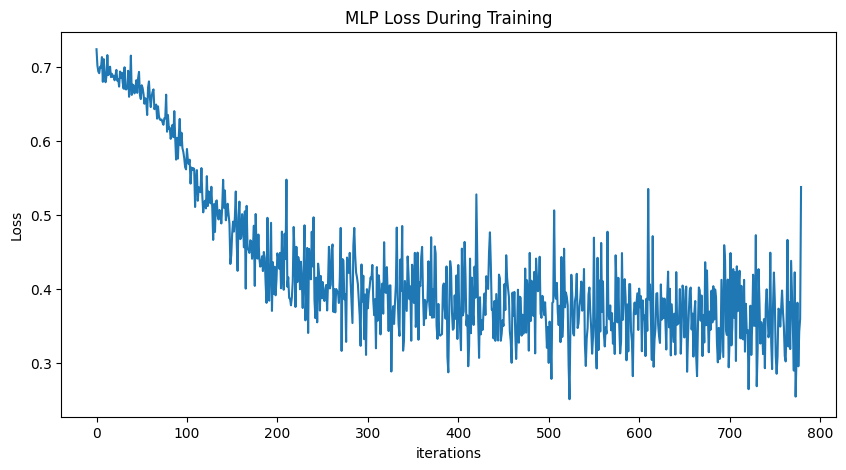

In [46]:
mlp_rn, mlp_rn_losses = train_mlp(X_rn_train, y_rn_train, device)
plt.figure(figsize=(10,5))
plt.title("MLP Loss During Training")
plt.plot(mlp_rn_losses, label="MLP - RESNET")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [47]:
rn_test_accuracy = get_mlp_accuracy(mlp_rn, X_rn_test, y_rn_test)

MLP Accuracy: 0.8236729502677917


## EfficientNET

In [48]:
efficientnet = models.efficientnet_b0(weights = 'DEFAULT')
if (device.type == 'cuda' and (NUM_GPU > 1)):
    efficientnet = nn.DataParallel(efficientnet, list(range(NUM_GPU)))
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, SIZE_Z) # type: ignore
summary(efficientnet, input_size=(BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [128, 128]                --
├─Sequential: 1-1                                       [128, 1280, 3, 3]         --
│    └─Conv2dNormActivation: 2-1                        [128, 32, 48, 48]         --
│    │    └─Conv2d: 3-1                                 [128, 32, 48, 48]         864
│    │    └─BatchNorm2d: 3-2                            [128, 32, 48, 48]         64
│    │    └─SiLU: 3-3                                   [128, 32, 48, 48]         --
│    └─Sequential: 2-2                                  [128, 16, 48, 48]         --
│    │    └─MBConv: 3-4                                 [128, 16, 48, 48]         1,448
│    └─Sequential: 2-3                                  [128, 24, 24, 24]         --
│    │    └─MBConv: 3-5                                 [128, 24, 24, 24]         6,004
│    │    └─MBConv: 3-6                              

In [50]:
# Getting train and test embeddings for the MLP

X_en_train, y_en_train = get_embeddings(efficientnet, dataloader, device)
X_en_test, y_en_test = get_embeddings(efficientnet, dataloader_test, device)

Epoch [1/20], Loss: 0.6995
Epoch [1/20], Loss: 0.6815
Epoch [1/20], Loss: 0.6852
Epoch [1/20], Loss: 0.6933
Epoch [1/20], Loss: 0.6968
Epoch [1/20], Loss: 0.6940
Epoch [1/20], Loss: 0.6845
Epoch [1/20], Loss: 0.6950
Epoch [1/20], Loss: 0.7005
Epoch [1/20], Loss: 0.6855
Epoch [1/20], Loss: 0.6865
Epoch [1/20], Loss: 0.6855
Epoch [1/20], Loss: 0.6901
Epoch [1/20], Loss: 0.6860
Epoch [1/20], Loss: 0.6801
Epoch [1/20], Loss: 0.6945
Epoch [1/20], Loss: 0.6865
Epoch [1/20], Loss: 0.6914
Epoch [1/20], Loss: 0.6801
Epoch [1/20], Loss: 0.6941
Epoch [1/20], Loss: 0.6965
Epoch [1/20], Loss: 0.6836
Epoch [1/20], Loss: 0.6969
Epoch [1/20], Loss: 0.6864
Epoch [1/20], Loss: 0.6846
Epoch [1/20], Loss: 0.6807
Epoch [1/20], Loss: 0.6886
Epoch [1/20], Loss: 0.6852
Epoch [1/20], Loss: 0.6829
Epoch [1/20], Loss: 0.6886
Epoch [1/20], Loss: 0.6826
Epoch [1/20], Loss: 0.6762
Epoch [1/20], Loss: 0.6822
Epoch [1/20], Loss: 0.6789
Epoch [1/20], Loss: 0.6806
Epoch [1/20], Loss: 0.6840
Epoch [1/20], Loss: 0.6782
E

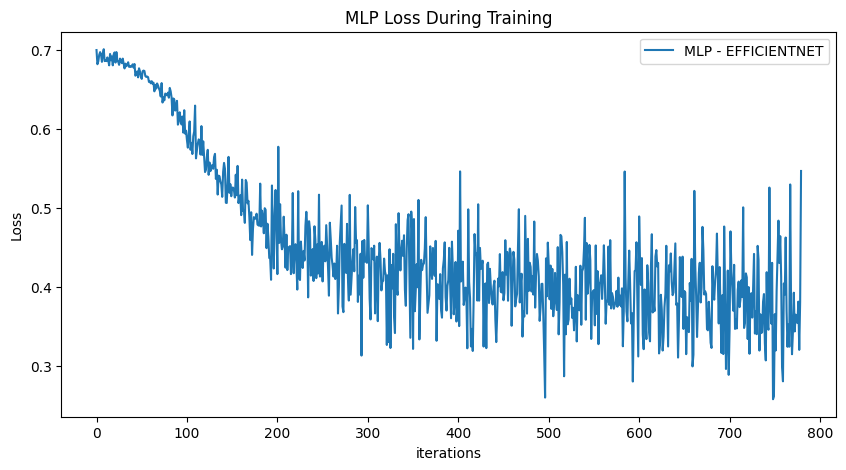

In [52]:
mlp_en, mlp_en_losses = train_mlp(X_en_train, y_en_train, device)
plt.figure(figsize=(10,5))
plt.title("MLP Loss During Training")
plt.plot(mlp_en_losses, label="MLP - EFFICIENTNET")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [53]:
en_test_accuracy = get_mlp_accuracy(mlp_en, X_en_test, y_en_test)

MLP Accuracy: 0.8267236351966858


## Evaluating Embeddings

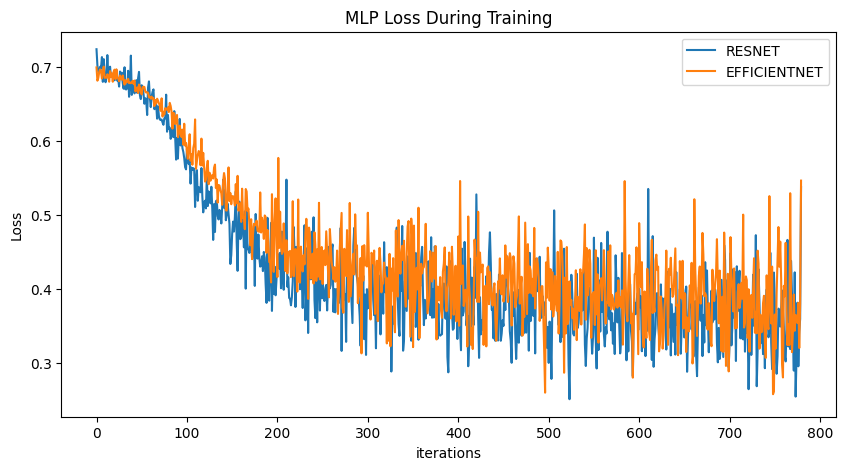

In [54]:
plt.figure(figsize=(10,5))
plt.title("MLP Loss During Training")
plt.plot(mlp_rn_losses, label="RESNET")
plt.plot(mlp_en_losses, label="EFFICIENTNET")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saliency MAPs of pretrained models